## Issues and fixes
#### 1. The Lower Salary was scrapped wrong for `Data Scientist` job title beacuse of an extra space after the comma in the salary information given on  the website, which was solved by replacing `', '` with `''` using replace function 
#### 2. The `na` values are either replaced with the correct values or are removed from the data frame.

In [51]:
import requests
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats


In [52]:
def Aldi_jobs(starting_page = 'head-office'):
    url = "https://www.aldirecruitment.co.uk/" + starting_page
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    data_set = []
    for data in soup.findAll('a'):
        new_link = data.get('href')
        if new_link != None and new_link.startswith('/head-office/'):
            new_link = new_link.replace('/head-office','')
            if new_link != '/':
                data_set.append(new_link)
    Departments = []
    title = []
    upper = []
    lower = []
    time = []
    holiday_allowance = []
    for data in data_set:
        url_by_cat = url + data
        page = requests.get(url_by_cat)
        soup = BeautifulSoup(page.content, "html.parser")
        postings = soup.findAll("div", class_="c-career--dropdown")
        for posting in postings:
            deptname = data.replace('-',' ').replace('/','')
            Departments.append(deptname)
            title.append(posting.find("div", class_="c-career--dropdown__content").find('h2').text)
            infos = posting.findAll("div", class_="c-job-details__content")
            for info in infos:
                info_title = info.find('span', class_="c-job-details__title").text
                info_text = info.find('div', class_="c-job-details__text").text
                
                if info_title == 'Salary':
                    # using .replace function to eleiminate the error in the salary of a data scientist
                    sal = info_text.replace(', ',',')
                    sal = sal.replace(',','')
                    sal = sal.replace('-','')
                    sal = sal.replace('£4.00','')
                    sal = sal.split()
                    salary_pounds = [float(s[1:]) for s in sal if s.startswith('£')]
                    
                    if len(salary_pounds) > 0:
                        if 'per' in sal and 'week'in sal:
                            salary_pounds = [salary*52 for salary in salary_pounds]
                        upper.append(max(salary_pounds))
                        lower.append(min(salary_pounds))
                    else:
                        upper.append(None)
                        lower.append(None)
                
                elif info_title.lower() == 'hours and benefits' or info_title.lower() == 'benefits':
                    work_hrs = None
                    for s in info_text.split():
                        if '-hour' in s:
                            work_hrs = s
                            if '-hours' in s:
                                work_hrs = int(work_hrs.replace('-hours',''))
                                
                            else:
                                work_hrs = int(work_hrs.replace('-hour',''))
                    time.append(work_hrs)
                # Adding holiday allowance information to the data frame   
                elif info_title == 'Holiday Allowance':
                   weeks = info_text.split()
                   holiday_allowance = weeks[0] 

    postings_data = pd.DataFrame(
        {'Department': Departments,
         'Job title': title,
         'Salary lower': lower,
         'Salary upper': upper,
         'Weekly hours': time,
         'Holiday allowance': holiday_allowance
        })
    return postings_data


In [74]:
aldi_postings = Aldi_jobs()
Aldi_jobs = aldi_postings.dropna(how='any',axis = 'rows')



In [75]:
Aldi_jobs.to_csv('Aldi_postings.csv', index=False)


# Data Pre-Processing Steps

In [55]:
path = "Aldi_postings_2021-09-30.csv"
df = pd.read_csv(path, sep=',')
df.head()


,Department,Job title,Salary lower,Salary upper,Weekly hours
0,national administration,National Finance & Administration Manager,54285.0,79040.0,50.0
1,national administration,National Tax Manager,44660.0,93655.0,50.0
2,national administration,Data Scientist,57130.0,74430.0,40.0
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,40.0
4,national administration,Technical Analyst,47100.0,54255.0,40.0


## Data Cleansing
### 1. Checking for Duplicates in the data frame using `.duplicated()` function which returns true or false if any
### 2. `print(df[duplicates])` returns the row with the duplicates if found any


In [56]:
duplicates = df.duplicated()
print(duplicates.any())
print(df[duplicates])


False
Empty DataFrame
Columns: [Department, Job title, Salary lower, Salary upper, Weekly hours]
Index: []


### As No duplicates were found, now we ckeck for any empty cells in the Data frame.

3. `.isna()` function returns True or False if the Data frame has any empty cells


In [57]:
df.isna().any()

Department      False
Job title       False
Salary lower     True
Salary upper     True
Weekly hours     True
dtype: bool

### As we detected NA cells associated with coloums `"Salary lower", "Salary upper", "Weekly hours"`, we use `.dropna(axis=0, how="any")` function to remove the empty cells


In [58]:
df.dropna(axis=0, inplace=True)
print(df.shape)

(92, 5)


## Data Scaling

In [59]:
from sklearn import preprocessing

### 1. Made a copy of the data frame `df` using `.copy()` function
### 2. Created a new data frame containing only columns having iterable data type for scaling from the original data
### 3. converting the new data frame `scaleable_faet` into an array of shape(92,5) usig `.to_numpy()` function
### 4. scaling the new array `Aldi_scale` using `preprocessing.scale(Aldi_scale)`

In [60]:
scaleable = df.copy()
col_names = ['Salary lower','Salary upper','Weekly hours']
scaleable_feat = scaleable[col_names]

Aldi_scale = scaleable_feat.to_numpy()


df_scaled = preprocessing.scale(Aldi_scale)
df_scaled 

array([[ 1.05378823,  1.37528389,  1.42855024],
       [ 0.38254556,  2.08481836,  1.42855024],
       [ 1.25219711,  1.15147589, -0.29620858],
       [ 0.55270994,  0.17201248, -0.29620858],
       [ 0.55270994,  0.17201248, -0.29620858],
       [ 0.19355152, -0.01150037, -0.29620858],
       [-0.49512603, -0.64360018, -0.29620858],
       [-0.49512603, -0.64360018, -0.29620858],
       [-1.17613224, -1.12932665, -0.29620858],
       [-2.04662066, -1.63898746, -2.0209674 ],
       [ 0.55270994,  0.17201248, -0.29620858],
       [ 0.14124689, -0.26637933, -0.29620858],
       [-0.49512603, -0.64360018, -0.29620858],
       [-0.72666117, -0.55257198, -0.29620858],
       [-0.72666117, -0.55257198, -0.29620858],
       [-0.72666117, -0.55257198, -0.29620858],
       [-0.72666117, -0.55257198, -0.29620858],
       [-0.72666117, -0.55257198, -0.29620858],
       [-1.25284568, -0.96353396, -0.29620858],
       [-2.04662066, -1.63898746, -2.0209674 ],
       [ 1.05378823,  1.37528389,  1.428

## Data Normalization

In [61]:
from sklearn import impute


### using `preprocessing.MinMaxScaler()` to normalize the certain columns of dataframe

In [62]:
min_max_scaler = preprocessing.MinMaxScaler()
Aldi_minmax = min_max_scaler.fit_transform(Aldi_scale)
Aldi_minmax


array([[0.62035225, 0.72260047, 1.        ],
       [0.49045145, 0.89269462, 1.        ],
       [0.6587489 , 0.66894778, 0.66666667],
       [0.52338214, 0.43414452, 0.66666667],
       [0.52338214, 0.43414452, 0.66666667],
       [0.45387678, 0.39015165, 0.66666667],
       [0.32060193, 0.23862063, 0.66666667],
       [0.32060193, 0.23862063, 0.66666667],
       [0.18881166, 0.12217916, 0.66666667],
       [0.02035225, 0.        , 0.33333333],
       [0.52338214, 0.43414452, 0.66666667],
       [0.44375464, 0.32905043, 0.66666667],
       [0.32060193, 0.23862063, 0.66666667],
       [0.27579459, 0.26044249, 0.66666667],
       [0.27579459, 0.26044249, 0.66666667],
       [0.27579459, 0.26044249, 0.66666667],
       [0.27579459, 0.26044249, 0.66666667],
       [0.27579459, 0.26044249, 0.66666667],
       [0.17396585, 0.16192405, 0.66666667],
       [0.02035225, 0.        , 0.33333333],
       [0.62035225, 0.72260047, 1.        ],
       [0.44375464, 0.32905043, 0.66666667],
       [0.

## Data Imputation


In [63]:
imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Aldi_scale)
print(imp.transform(Aldi_scale))
df


[[5.42850e+04 7.90400e+04 5.00000e+01]
 [4.46600e+04 9.36550e+04 5.00000e+01]
 [5.71300e+04 7.44300e+04 4.00000e+01]
 [4.71000e+04 5.42550e+04 4.00000e+01]
 [4.71000e+04 5.42550e+04 4.00000e+01]
 [4.19500e+04 5.04750e+04 4.00000e+01]
 [3.20750e+04 3.74550e+04 4.00000e+01]
 [3.20750e+04 3.74550e+04 4.00000e+01]
 [2.23100e+04 2.74500e+04 4.00000e+01]
 [9.82800e+03 1.69520e+04 3.00000e+01]
 [4.71000e+04 5.42550e+04 4.00000e+01]
 [4.12000e+04 4.52250e+04 4.00000e+01]
 [3.20750e+04 3.74550e+04 4.00000e+01]
 [2.87550e+04 3.93300e+04 4.00000e+01]
 [2.87550e+04 3.93300e+04 4.00000e+01]
 [2.87550e+04 3.93300e+04 4.00000e+01]
 [2.87550e+04 3.93300e+04 4.00000e+01]
 [2.87550e+04 3.93300e+04 4.00000e+01]
 [2.12100e+04 3.08650e+04 4.00000e+01]
 [9.82800e+03 1.69520e+04 3.00000e+01]
 [5.42850e+04 7.90400e+04 5.00000e+01]
 [4.12000e+04 4.52250e+04 4.00000e+01]
 [4.12000e+04 4.52250e+04 4.00000e+01]
 [3.20750e+04 3.74550e+04 4.00000e+01]
 [3.20750e+04 3.74550e+04 4.00000e+01]
 [3.20750e+04 3.74550e+04

,Department,Job title,Salary lower,Salary upper,Weekly hours
0,national administration,National Finance & Administration Manager,54285.0,79040.0,50.0
1,national administration,National Tax Manager,44660.0,93655.0,50.0
2,national administration,Data Scientist,57130.0,74430.0,40.0
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,40.0
4,national administration,Technical Analyst,47100.0,54255.0,40.0
...,...,...,...,...,...
94,quality assurance,Sampling Chef,30350.0,36055.0,40.0
95,quality assurance,Sampling Assistant,25670.0,31100.0,40.0
96,quality control,Quality Control Leader,46435.0,50430.0,48.0
97,quality control,Quality Control Deputy,8320.0,28662.4,20.0


### Further i would like to add few features to the Dataframe they are `Hours_per_day` and `Avg_min_salary`
### `Hours_per_day` feature gives the number of hours per day a person under a posting is equired to work  
### `avg_mi_salary` feature gives us an estimate of minimum average salary being offered in a particular department

In [64]:
df = df.assign(Hours_per_day=df["Weekly hours"]/7)
df


,Department,Job title,Salary lower,Salary upper,Weekly hours,Hours_per_day
0,national administration,National Finance & Administration Manager,54285.0,79040.0,50.0,7.142857
1,national administration,National Tax Manager,44660.0,93655.0,50.0,7.142857
2,national administration,Data Scientist,57130.0,74430.0,40.0,5.714286
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,40.0,5.714286
4,national administration,Technical Analyst,47100.0,54255.0,40.0,5.714286
...,...,...,...,...,...,...
94,quality assurance,Sampling Chef,30350.0,36055.0,40.0,5.714286
95,quality assurance,Sampling Assistant,25670.0,31100.0,40.0,5.714286
96,quality control,Quality Control Leader,46435.0,50430.0,48.0,6.857143
97,quality control,Quality Control Deputy,8320.0,28662.4,20.0,2.857143


In [65]:
df_mean = pd.DataFrame(df.groupby("Department")["Salary lower"].transform(np.mean))
df = df.assign(Avg_min_salary = df_mean["Salary lower"])
df


,Department,Job title,Salary lower,Salary upper,Weekly hours,Hours_per_day,Avg_min_salary
0,national administration,National Finance & Administration Manager,54285.0,79040.0,50.0,7.142857,39145.230769
1,national administration,National Tax Manager,44660.0,93655.0,50.0,7.142857,39145.230769
2,national administration,Data Scientist,57130.0,74430.0,40.0,5.714286,39145.230769
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,40.0,5.714286,39145.230769
4,national administration,Technical Analyst,47100.0,54255.0,40.0,5.714286,39145.230769
...,...,...,...,...,...,...,...
94,quality assurance,Sampling Chef,30350.0,36055.0,40.0,5.714286,36716.000000
95,quality assurance,Sampling Assistant,25670.0,31100.0,40.0,5.714286,36716.000000
96,quality control,Quality Control Leader,46435.0,50430.0,48.0,6.857143,25718.866667
97,quality control,Quality Control Deputy,8320.0,28662.4,20.0,2.857143,25718.866667


# Boxplot

<AxesSubplot:xlabel='Department', ylabel='Salary lower'>

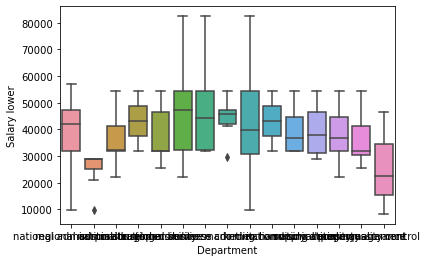

In [66]:
sns.boxplot(x='Department',y='Salary lower',data=df)

# T-test


In [67]:
qual_assur = df[df['Department'] == 'quality assurance']['Salary lower']
qual_cont = df[df['Department'] == 'quality control']['Salary lower']
stats.ttest_ind(qual_assur, qual_cont)


Ttest_indResult(statistic=1.0408933615261715, pvalue=0.3380392136176305)

In [68]:
stats.ttest_ind(df['Salary lower'], df['Weekly hours'])



Ttest_indResult(statistic=26.034058519133065, pvalue=2.883586665958914e-63)

# Correlation

In [72]:
corr_matrix = df.corr(method='pearson', min_periods=1)
corr_matrix


,Salary lower,Salary upper,Weekly hours,Hours_per_day,Avg_min_salary
Salary lower,1.000000,0.928708,0.743500,0.743500,0.412004
Salary upper,0.928708,1.000000,0.788800,0.788800,0.339699
Weekly hours,0.743500,0.788800,1.000000,1.000000,0.321824
Hours_per_day,0.743500,0.788800,1.000000,1.000000,0.321824
Avg_min_salary,0.412004,0.339699,0.321824,0.321824,1.000000


# Heat Map

In [70]:
def corr(corr_matrix):
  
    sns.set(style="darkgrid")
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(0, 15, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1,square=True, linewidths=1, cbar_kws={"shrink": .5})
plt.show()



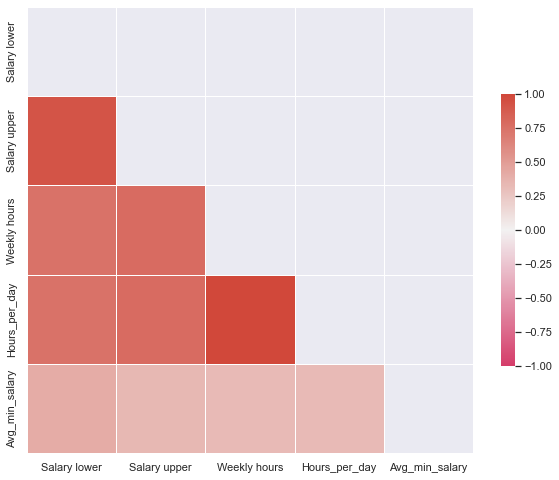

In [71]:
corr(df.corr(method='pearson', min_periods=1))
